In [1]:
# Examine wind case results
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw
import cmocean
import utide
from pandas import date_range
import sys
sys.path.append(os.path.abspath('../TEF'))
import TEF_Variables as tef
sys.path.append(os.path.abspath('/work/oceans/wbao/MITgcm_results/jorgemontt'))

In [2]:
# Calculate volume temperature for the Storage term dT/dt
def vol_temp(datapath, case_id, xi):
    
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())    
    # Confine to the range of fjord
    state = State.isel(X=range(200), Xp1=range(201), Y=range(35,45))
    grid = Grid.isel(X=range(200), Xp1=range(201), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    Time = state.T.data
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC

    rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    CV = rA * drF * HFacC
    
    da = DA[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    cv = CV[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    s = state.S.data[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    temp = state.Temp.data[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    u = U[:,:,:,xi[0]+1:xi[1]+1].mean(2)
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    
    vTemp1 = np.empty(len(Time))
    vTemp2 = np.empty(len(Time))
    Tvol = np.empty(len(Time))
    
    for tt in range(len(Time)):
        
        Temp_t = temp[tt,:,:]
        U_t = u[tt,:,:]
        Area_t = da[tt,:,:]
        Vol_t = cv[tt,:,:]
        
        xTemp1 = np.empty(Temp_t.shape[1])
        xTemp2 = np.empty(Temp_t.shape[1]
                         )
        for i in range(Temp_t.shape[1]):

            xTemp1[i] = np.sum(Temp_t[:,i]*Area_t[:,i]*U_t[:,i]) / np.sum(Area_t[:,i]*U_t[:,i])
            xTemp2[i] = np.sum(Temp_t[:,i]*Area_t[:,i]) / np.sum(Area_t[:,i])
            Tvol[i] = Vol_t[:,i].sum()
            
        vTemp1[tt] = xTemp1[:-1].mean() # Average in x direction
        vTemp2[tt] = xTemp2[:-1].mean()
        Volume = Tvol[:-1].sum()
        
    return vTemp2, Time

In [4]:
path1 = '/work/oceans/wbao/MITgcm_results/jorgemontt/Qsg150_wind'
caseid = [1,2,3,4,5]
taum = np.array([-0.2, -0.1, 0, 0.1, 0.2]) # maximum wind stress
xrange = np.array([0,97]) # X index range for the segment between glacier and outer sill


Tv = []
for i in caseid:
    vTemp, model_time = vol_temp(path1,i,xrange)
    Tv.append(vTemp)

In [10]:
array_2d = np.array(Tv)

IndexError: list index out of range

In [11]:
def godin_shape():
    """
    Based on matlab code of 4/8/2013  Parker MacCready
    Returns a 71 element numpy array that is the weights
    for the Godin 24-24-25 tildal averaging filter. This is the shape given in
    Emery and Thomson (1997) Eqn. (5.10.37)
    ** use ONLY with hourly data! **
    """
    k = np.arange(12)
    filt = np.NaN * np.ones(71)
    filt[35:47] = (0.5/(24*24*25))*(1200-(12-k)*(13-k)-(12+k)*(13+k))
    k = np.arange(12,36)
    filt[47:71] = (0.5/(24*24*25))*(36-k)*(37-k)
    filt[:35] = filt[:35:-1]
    return filt

def filt_godin(data):
    """
    Input: 1D numpy array of HOURLY values
    Output: Array of the same size, filtered with 24-24-25 Godin filter,
        padded with nan's
    """
    filt = godin_shape()
    npad = np.floor(len(filt)/2).astype(int)
    smooth = np.convolve(data, filt, mode = 'same')
    smooth[:npad] = np.nan
    smooth[-npad:] = np.nan
    # smooth[:npad] = data[:npad]
    # smooth[-npad:] = data[-npad:]
    return smooth

## Volume Temp

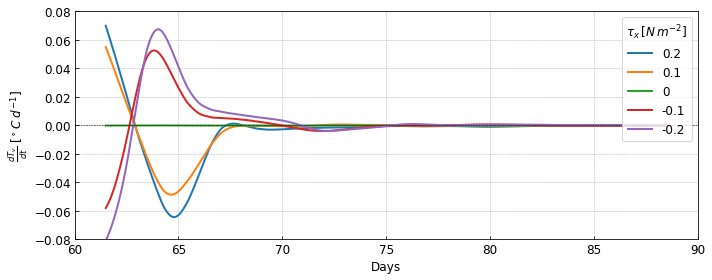

In [48]:
day = model_time / 86400 # days

fig0 = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig0.add_subplot(111)

dt = 3600 # time interval of 0.5 day
plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(day[1:],24*np.diff(filt_godin(Tv[4])),lw=2,label=r'0.2')
ax1.plot(day[1:],24*np.diff(filt_godin(Tv[3])),lw=2,label=r'0.1')
ax1.plot(day[1:],24*np.diff(filt_godin(Tv[2])),lw=2,label=r'0')
ax1.plot(day[1:],24*np.diff(filt_godin(Tv[1])),lw=2,label=r'-0.1')
ax1.plot(day[1:],24*np.diff(filt_godin(Tv[0])),lw=2,label=r'-0.2')
ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)
# ax1.set_xlim([60,90])
# ax1.set_ylim([60,90])
ax1.set(xlim=(60, 90), ylim=(-0.08, 0.08))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$\frac{dT_v}{dt}$ [$^\circ C\;d^{-1}$]',fontsize=12)

fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"

fig0.savefig(fig_path + 'volTemp_singlewind.png', dpi=300, bbox_inches='tight')

## TEF

In [26]:
# Calculate TEF transports
def tef_transport(datapath, case_id, xi):    
    
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())
    # Confine to the range of fjord
    state = State.isel(X=range(200), Xp1=range(201), Y=range(35,45))
    grid = Grid.isel(X=range(200), Xp1=range(201), Y=range(35,45))
    
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
#     Qin = np.empty(len(xi))
#     Qout = np.empty(len(xi))
#     Sin = np.empty(len(xi))
#     Sout = np.empty(len(xi))
    
#     t0 = 89 # 274
#     # Exclude the upper (surface) layer for TEF calculation
#     for t in range(U.shape[0]):
        
#         Uzx = u[t,:,:] # Steady-state along-channel velocity
#         for j in range(Uzx.shape[1]):
#             if any(Uzx[:,j]>0)==False:
#                 pass
#             else:
#                 mid = np.where(Uzx[:,j]>0)[0][0]
#                 if mid>0:
#                     S[t,:mid,:,j] = 0
#                     U[t,:mid,:,j] = 0
#                 else:
#                     pass
    
    
               
    tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi,23,testing=False)

    qin, qout, sin, sout = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
#     Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
#     Qout[i] = qout1[t0:].mean()
#     Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
#     Sout[i] = sout1[t0:].mean()
        
    return qin, qout, sin, sout

In [62]:
Qin = []
Qout = []
Sin = []
Sout = []
xid = 95 # index for outer sill

for i in caseid:    
    qin, qout, sin, sout = tef_transport(path1,i,xid)
   
    Qin.append(qin)
    Qout.append(qout)
    Sin.append(sin)
    Sout.append(sout)


  time 0 out of 721


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:268: RuntimeWarning: invalid value encountered in true_divide
  Sp = QSp/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:272: RuntimeWarning: invalid value encountered in true_divide
  S2p = QS2p/Qp


  time 0 out of 721


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


  time 0 out of 721
  time 0 out of 721
  time 0 out of 721


In [65]:
def volflux_ts(datapath, case_id, xi):
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())
    state = State.isel(X=range(200), Xp1=range(201), Y=range(35,45))
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    grid = Grid.isel(X=range(200), Xp1=range(201), Y=range(35,45))  
    
    time = state.T.data / 86400
    
    Area = np.empty([90, 10]) # Cross Y direction
    Area[:20, :] = 400
    Area[20:50, :] = 800
    Area[50:, :] = 1200

    HFacW = grid.HFacW.data[:,:,xi] # vertical fraction of open cell at West face
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    Q1 = np.empty(len(time))
    Q2 = np.empty(len(time))
    for t in range(len(time)):
        Q = U[t,:,:,xi] * Area * HFacW
        Q1[t] = Q[Q > 0].sum()
        Q2[t] = Q[Q < 0].sum()
    
    return time, Q1, Q2

In [66]:
Qp = []
Qn = []
#xid = 95 # index for outer sill

for i in caseid:    
    time, q1, q2 = volflux_ts(path1,i,xid)
   
    Qp.append(q1)
    Qn.append(q2)

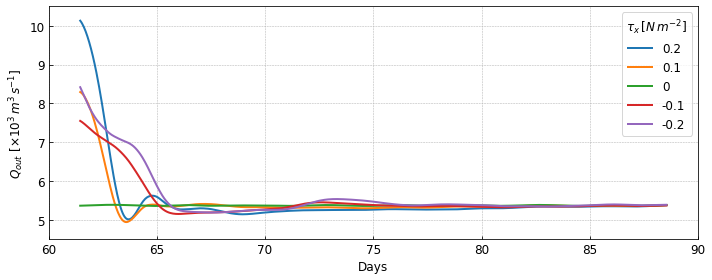

In [67]:

fig1 = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig1.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(day,filt_godin(Qin[4])/1e3,lw=2,label=r'0.2')
ax1.plot(day,filt_godin(Qin[3])/1e3,lw=2,label=r'0.1')
ax1.plot(day,filt_godin(Qin[2])/1e3,lw=2,label=r'0')
ax1.plot(day,filt_godin(Qin[1])/1e3,lw=2,label=r'-0.1')
ax1.plot(day,filt_godin(Qin[0])/1e3,lw=2,label=r'-0.2')
#ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)
ax1.set(xlim=(60, 90), ylim=(4.5, 10.5))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$Q_{out}$ [$\times 10^3\,m^3\,s^{-1}$]',fontsize=12)

fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"

#fig0.savefig(fig_path + 'volTemp_singlewind.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, '$Q_{out}$ [$\\times 10^3\\,m^3\\,s^{-1}$]')

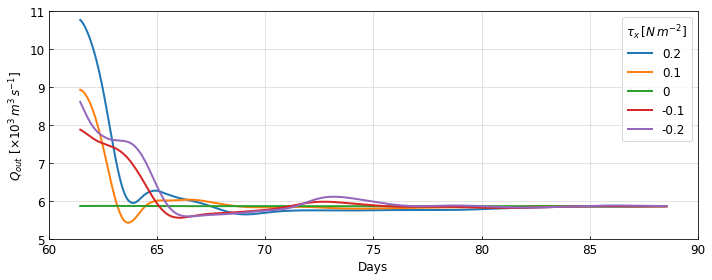

In [74]:

fig1s = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig1s.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(day,filt_godin(Qp[4])/1e3,lw=2,label=r'0.2')
ax1.plot(day,filt_godin(Qp[3])/1e3,lw=2,label=r'0.1')
ax1.plot(day,filt_godin(Qp[2])/1e3,lw=2,label=r'0')
ax1.plot(day,filt_godin(Qp[1])/1e3,lw=2,label=r'-0.1')
ax1.plot(day,filt_godin(Qp[0])/1e3,lw=2,label=r'-0.2')
#ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)
ax1.set(xlim=(60, 90), ylim=(5, 11))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$Q_{out}$ [$\times 10^3\,m^3\,s^{-1}$]',fontsize=12)


In [42]:
## Profiles

In [43]:
# Get vertical profiles at selected location
def z_prof(datapath, case_id, xi):
    
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())    
    # Confine to the range of fjord
    state = State.isel(X=range(200), Xp1=range(201), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    Utz = U[:,:,:,xi].mean(2)
    Depth = state.Z.data
    
    return Utz, Depth

In [45]:
day[72]

63.0

In [69]:
Uz = []
#xid = 70 # index for outer sill

for i in caseid:    
    Utz, Depth = z_prof(path1,i,xid)
    u = Utz[:73,:].mean(0) # Average during the 3-day wind
    Uz.append(u)


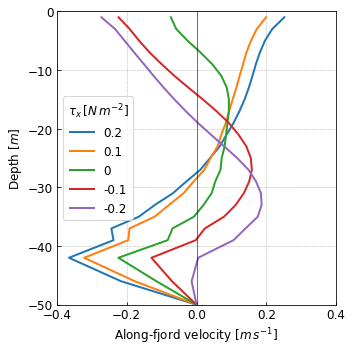

In [72]:
fig2 = plt.figure(figsize=(5,5), tight_layout=True)    
ax1 = fig2.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(Uz[4],Depth,lw=2,label=r'0.2')
ax1.plot(Uz[3],Depth,lw=2,label=r'0.1')
ax1.plot(Uz[2],Depth,lw=2,label=r'0')
ax1.plot(Uz[1],Depth,lw=2,label=r'-0.1')
ax1.plot(Uz[0],Depth,lw=2,label=r'-0.2')
ax1.axvline(x=0, color='k',linestyle='-', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='best',fontsize=12)
ax1.set(xlim=(-.4,.4),ylim=(-50, 0))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel(r'Along-fjord velocity [$m\,s^{-1}$]',fontsize=12)
ax1.set_ylabel(r'Depth [$m$]',fontsize=12)

fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"